# ML - Домашнее задание 4
## Кластеризация

**Дедлайн:** 23:59, 9 апреля

### Что нужно сделать:
- На примере произвольного датасета (можно использовать датасет с предыдущих заданий)
  - провести кластеризацию методом, который наиболее хорошо подходит под ваши данные
  - провести сравнительный анализ и получить аргументы в пользу того или иного метода (можно использовать информацию с лекции/семинара)
  - прописать выводы по выбору метода на основе анализа (**выводы и обоснование очень важны**)

### Формат сдачи:
- `.ipynb`, сконвертированный в **HTML-файл** или ссылка на **Google Colab** с открытым доступом

---

### Условия для зачета:
- **На 4:** проведена кластеризация подходящим методом, прописан сравнительный анализ
- **На 5:** работа содержит аргументированные выводы по выбору метода на основе анализа

**ВАЖНО!** Ссылки должны быть рабочие и с открытым доступом для скачивания.

**Желаем удачи!**


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from itertools import product

import plotly as py
import plotly.graph_objs as go

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, OPTICS, estimate_bandwidth, MeanShift, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

### Credit Risk Analysis for extending Bank Loans

[Link](https://www.kaggle.com/datasets/atulmittal199174/credit-risk-analysis-for-extending-bank-loans)

Нет описания к данным, но датасет показался мне достаточно интересным. Учитывая контекст задания, придумаю собственные полные описания переменных:

| Колонка    | Полное название | Описание |
|------------|----------------|----------|
| **age** | Age of the Customers | Возраст клиента в годах на момент подачи заявки |
| **ed** | Education Level | Уровень образования клиента (1, 2, 3, 4, 5) |
| **employ** | Work Experience | Количество лет трудового стажа клиента |
| **address** | Address of the Customer | Количество лет проживания клиента по текущему адресу |
| **income** | Yearly Income of the Customer | Годовой доход клиента (в тысячах долларов или другой валюте) |
| **debtinc** | Debt to Income Ratio | Соотношение общей суммы долга к годовому доходу |
| **creddebt** | Credit to Debt Ratio | Сумма задолженности по кредитным картам относительно общего долга |
| **othdebt** | Other Debts | Сумма других долгов, таких как ипотека или автокредит |
| **default** | Customer Defaulted in the Past (1 = defaulted, 0 = Never Defaulted) | Факт дефолта: 1 – клиент допускал дефолт, 0 – не допускал |


In [5]:
# Загружаю данные
df = pd.read_csv('bankloans.csv')
df

age  ed  employ  address  income  debtinc   creddebt   othdebt  default
0      41   3      17       12     176      9.3  11.359392  5.008608      1.0
1      27   1      10        6      31     17.3   1.362202  4.000798      0.0
2      40   1      15       14      55      5.5   0.856075  2.168925      0.0
3      41   1      15       14     120      2.9   2.658720  0.821280      0.0
4      24   2       2        0      28     17.3   1.787436  3.056564      1.0
...   ...  ..     ...      ...     ...      ...        ...       ...      ...
1145   34   1      12       15      32      2.7   0.239328  0.624672      NaN
1146   32   2      12       11     116      5.7   4.026708  2.585292      NaN
1147   48   1      13       11      38     10.8   0.722304  3.381696      NaN
1148   35   2       1       11      24      7.8   0.417456  1.454544      NaN
1149   37   1      20       13      41     12.9   0.899130  4.389870      NaN

[1150 rows x 9 columns]

In [6]:
df.describe()

age           ed       employ      address       income  \
count  1150.000000  1150.000000  1150.000000  1150.000000  1150.000000   
mean     35.235652     1.695652     8.781739     8.485217    47.982609   
std       8.089961     0.927051     6.914762     6.977725    40.508814   
min      20.000000     1.000000     0.000000     0.000000    13.000000   
25%      29.000000     1.000000     3.000000     3.000000    24.000000   
50%      35.000000     1.000000     7.000000     7.000000    36.000000   
75%      41.000000     2.000000    13.000000    12.000000    56.750000   
max      56.000000     5.000000    33.000000    34.000000   446.000000   

           debtinc     creddebt      othdebt     default  
count  1150.000000  1150.000000  1150.000000  700.000000  
mean     10.063391     1.605111     3.103844    0.261429  
std       6.584288     2.135967     3.529273    0.439727  
min       0.100000     0.011696     0.045584    0.000000  
25%       5.200000     0.415584     1.047996    0.000000  
50%       8.750000     0.899130     2.038053    0.000000  
75%      13.600000     1.898820     3.864960    1.000000  
max      41.300000    20.561310    35.197500    1.000000

In [7]:
np.quantile(df['income'], q=[0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999, 0.9999])

array([ 56.75  ,  64.    ,  73.    ,  89.    , 119.1   , 126.12  ,
       139.53  , 166.06  , 245.57  , 266.    , 324.    , 431.9822])

## Мысли

Интересно, что если мы смотрим на пункт дохода, можно заметить, что 75%-перцентиль находится на отметке 56.75 тыс. долл., а максимальное значение - 446 тыс. долл.
Посмотрев внимательнее на разбивку по перцентилям, можно заметить, что даже на отметке 0.999 (99.9%) находится 324 тыс. долл. (все равно не максимум!).

**Выхода тут два (если цель в дальнейшем построить модель классификации):**
- Мы либо удаляем выбросы (неоднозначное решение для скоринговой задачи)
- Или мы смотрим на робастные к выбросам метрики для нашей будущей предиктивной модели (можно забыть про квадратичные функционалы; можно подумать насчет комбинированных функций потерь или функционалы с логарифмами)

При дальнейшем анализе обнаружил, что у нас всего лишь 1 наблюдение на отметке за 400 тыс. долл. и 1 на отметке за 300 тыс. долл. Руководствуясь собственной интуицией, мне кажется, что данных клиентов банка включать в модель будет нерационально, так как они будут вносить существенное смещение в наши оценки, предсказания. Предлагаю отфильтровать их.

**Сделаю так: оценю наличие выбросов методом Тьюки.**

In [9]:
quantitative_columns = ['income']

def detect_outliers_tukey(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    extreme_lower_bound = Q1 - 3 * IQR
    extreme_upper_bound = Q3 + 3 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    extreme_outliers = df[(df[column] < extreme_lower_bound) | (df[column] > extreme_upper_bound)]

    print(f"Для переменной '{column}':")
    print(f"- Межквартильный размах (IQR): {IQR:.2f}")
    print(f"- Границы выбросов: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"- Границы экстремальных выбросов: ({extreme_lower_bound:.2f}, {extreme_upper_bound:.2f})")
    print(f"- Найдено выбросов: {len(outliers)}")
    print(f"- Найдено экстремальных выбросов: {len(extreme_outliers)}")
    
    return outliers, extreme_outliers

for col in quantitative_columns:
    outliers, extreme_outliers = detect_outliers_tukey(df, col)
    print("-" * 50)

print(f"Минимальное значение в выбросах по колонке income:\n{extreme_outliers['income'].min()} тыс. долл.")

Для переменной 'income':
- Межквартильный размах (IQR): 32.75
- Границы выбросов: (-25.12, 105.88)
- Границы экстремальных выбросов: (-74.25, 155.00)
- Найдено выбросов: 82
- Найдено экстремальных выбросов: 26
--------------------------------------------------
Минимальное значение в выбросах по колонке income:
157 тыс. долл.


In [10]:
df = df[df['income'] < 157]
df = df.reset_index(drop=True)
df

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
0      27   1      10        6      31     17.3  1.362202  4.000798      0.0
1      40   1      15       14      55      5.5  0.856075  2.168925      0.0
2      41   1      15       14     120      2.9  2.658720  0.821280      0.0
3      24   2       2        0      28     17.3  1.787436  3.056564      1.0
4      41   2       5        5      25     10.2  0.392700  2.157300      0.0
...   ...  ..     ...      ...     ...      ...       ...       ...      ...
1119   34   1      12       15      32      2.7  0.239328  0.624672      NaN
1120   32   2      12       11     116      5.7  4.026708  2.585292      NaN
1121   48   1      13       11      38     10.8  0.722304  3.381696      NaN
1122   35   2       1       11      24      7.8  0.417456  1.454544      NaN
1123   37   1      20       13      41     12.9  0.899130  4.389870      NaN

[1124 rows x 9 columns]

In [11]:
df = df.reset_index(drop=True)
df

age  ed  employ  address  income  debtinc  creddebt   othdebt  default
0      27   1      10        6      31     17.3  1.362202  4.000798      0.0
1      40   1      15       14      55      5.5  0.856075  2.168925      0.0
2      41   1      15       14     120      2.9  2.658720  0.821280      0.0
3      24   2       2        0      28     17.3  1.787436  3.056564      1.0
4      41   2       5        5      25     10.2  0.392700  2.157300      0.0
...   ...  ..     ...      ...     ...      ...       ...       ...      ...
1119   34   1      12       15      32      2.7  0.239328  0.624672      NaN
1120   32   2      12       11     116      5.7  4.026708  2.585292      NaN
1121   48   1      13       11      38     10.8  0.722304  3.381696      NaN
1122   35   2       1       11      24      7.8  0.417456  1.454544      NaN
1123   37   1      20       13      41     12.9  0.899130  4.389870      NaN

[1124 rows x 9 columns]

In [12]:
df[df['default'] == 1].count()

age         179
ed          179
employ      179
address     179
income      179
debtinc     179
creddebt    179
othdebt     179
default     179
dtype: int64

In [13]:
df[df['default'] == 0].count()

age         507
ed          507
employ      507
address     507
income      507
debtinc     507
creddebt    507
othdebt     507
default     507
dtype: int64

In [14]:
df['default'].isna().sum()

438

##### Абсолютное значение задолженности `debt`

In [16]:
df['debt'] = df['debtinc'] * df['income']

In [17]:
# сохраню предобработанный набор данных на будущее

df_initial = df

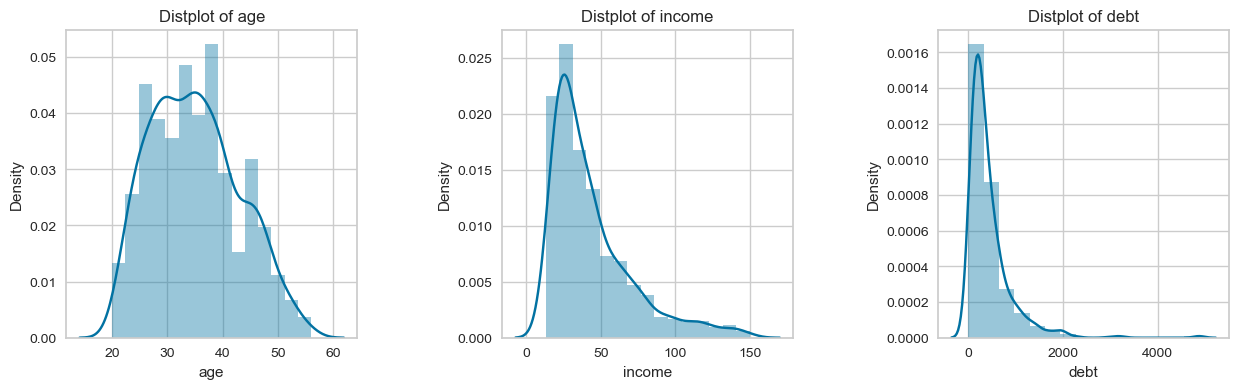

In [18]:
plt.figure(1 , figsize = (15 , 4))
n = 0 
for x in ['age' , 'income' , 'debt']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

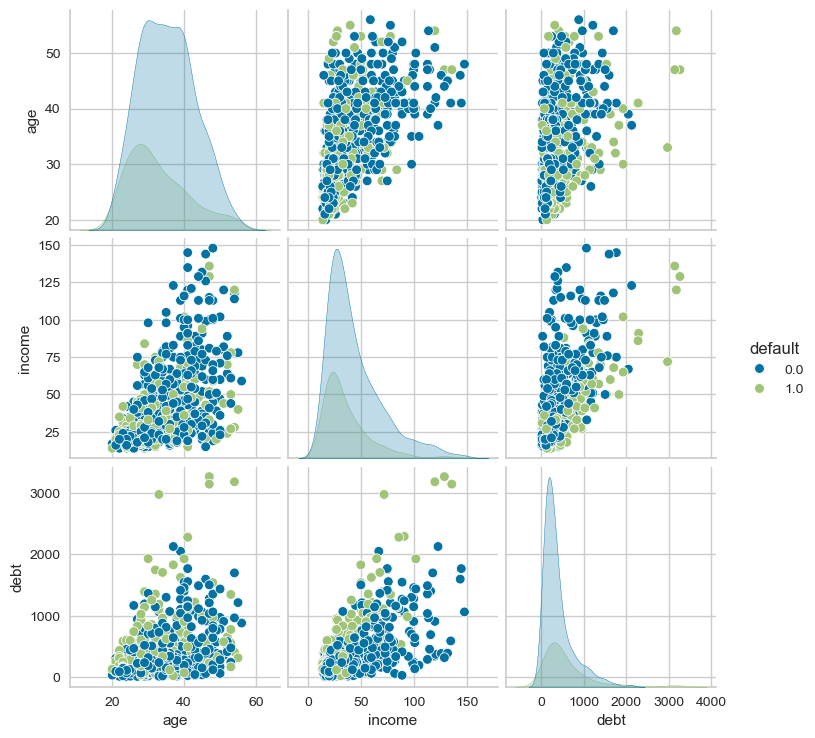

In [19]:
sns.pairplot(df, vars = ['age' , 'income' , 'debt'], hue = "default")

#### Интересная визуализация

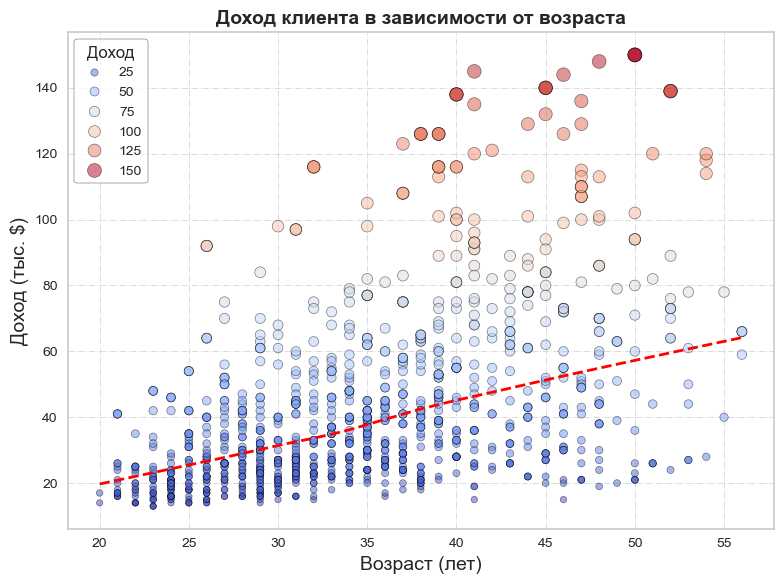

In [21]:
# plt.figure(figsize=(6, 5))
plt.figure(figsize=(8, 6))


sns.set_style("whitegrid")
palette = sns.color_palette("coolwarm", as_cmap=True)


sns.scatterplot(data=df,
                x='age',
                y='income',
                hue='income',
                palette=palette,
                size="income",
                sizes=(20, 100), 
                s=80,  
                alpha=0.5, 
                edgecolor="black",
                linewidth=0.5
                # marker='o'
)

sns.regplot(data=df, 
            x='age', 
            y='income', 
            scatter=False, 
            # order=2,
            lowess=True,
            # lowess=True, 
            color='red', 
            line_kws={'linewidth': 2, 'linestyle': '--'})

# sns.stripplot(data=df, x='employ', y='income', jitter=True, alpha=0.3)

# key_points = [5, 10, 15, 20, 25, 30]
# for iter in key_points:
#     median_income = df[df['age'] == iter]['income'].median()
#     plt.text(iter, median_income + 5, f"{int(median_income)} тыс. $", fontsize=10, ha='center', color='black', fontweight='bold')
# plt.axvline(x, linestyle='--', color='gray', alpha=0.5)

plt.title('Доход клиента в зависимости от возраста', fontsize=14, fontweight='bold')
plt.xlabel('Возраст (лет)', fontsize=14)
plt.ylabel('Доход (тыс. $)', fontsize=14)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)


plt.grid(True, linestyle='-.', linewidth=0.7, alpha=0.7) 
# plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(title="Доход", fontsize=10, title_fontsize=12, frameon=True, edgecolor="black", facecolor="white")

plt.tight_layout()

## Кластеризация
### Идея

- Предлагаю посмотреть на кластеризацию в контексте заработка клиента, его возраста, а также его задолженности в численном выражении;
- То есть, проведем кластеризацию по общей сумме долга (`debt`, получим из коэффициента задолженности относительно годового дохода), возрасту клиента в годах на момент подачи заявки, а также его годовом доходе (в тысячах долларов или другой валюте);
- Единственное, без описания не очень понятно, `ratios` даны в процентах или в абсолютном значении, решил сделать предположение, что в абсолютном.

In [23]:
df = df.drop(['ed', 'employ', 'address', 'creddebt', 'othdebt', 'default', 'debtinc'], axis=1)
df

age  income   debt
0      27      31  536.3
1      40      55  302.5
2      41     120  348.0
3      24      28  484.4
4      41      25  255.0
...   ...     ...    ...
1119   34      32   86.4
1120   32     116  661.2
1121   48      38  410.4
1122   35      24  187.2
1123   37      41  528.9

[1124 rows x 3 columns]

## K-means++

In [25]:
# технические параметры k-means, которые мы будем использовать дальше
kmeans_params = {
    'init': 'k-means++',
    'n_init': 10,
    'max_iter': 300, 
    'tol': 0.0001,
    'random_state': 42,
    'algorithm': 'elkan'
}

In [26]:
X3 = df[['age' , 'income' , 'debt']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = KMeans(n_clusters = n, **kmeans_params)
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

  File "D:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Выберем оптимальное количество кластеров с помощью **метода локтя (elbow method)**

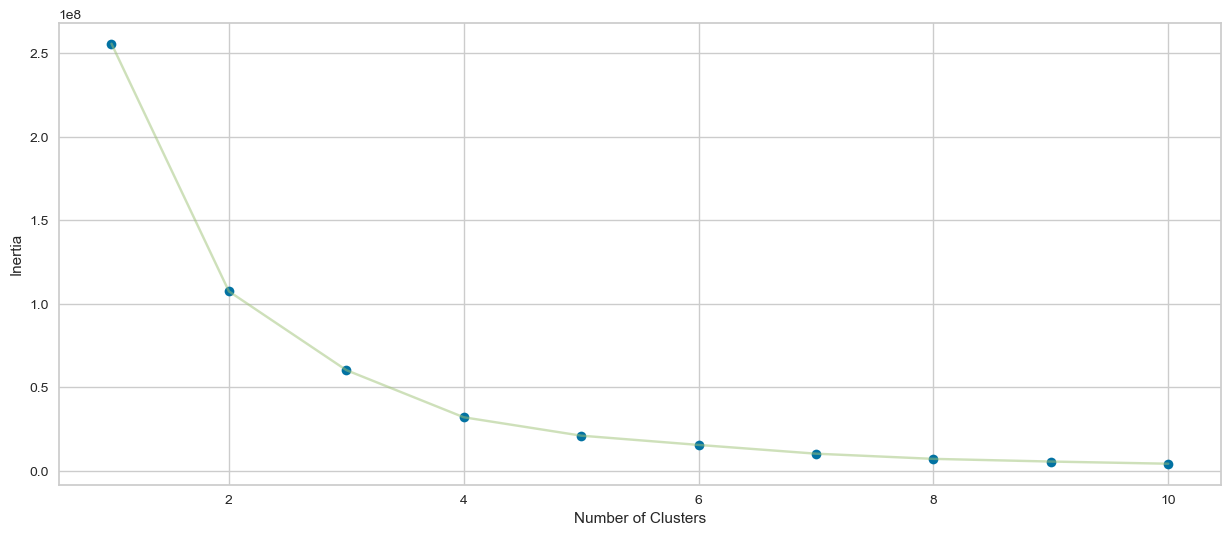

In [28]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

Можно отметить, что внутрикластерное расстояние уменьшается нерадикально после $K=4$, => я бы выбрал $4$ кластера

Посмотрим на distortion (сумма квадратов расстояний до центров кластеров) и silhouette (соотношение внутрикластерных и межкластерных расстояний)

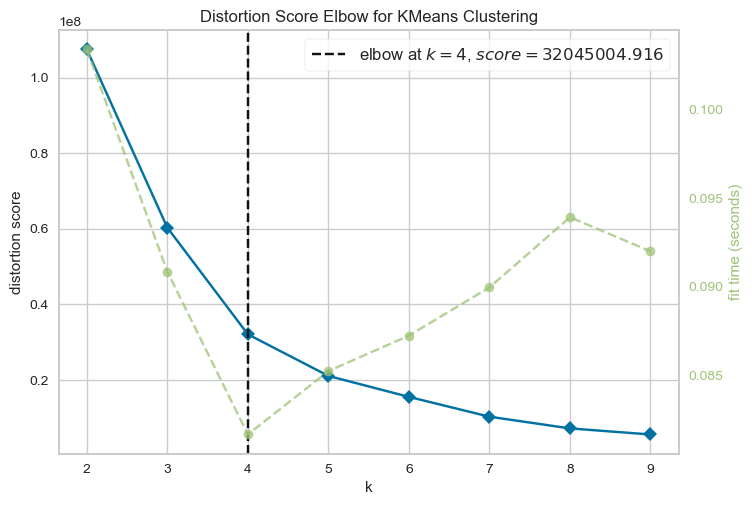

In [31]:
model = KMeans(**kmeans_params)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X3)
visualizer.show()
plt.show()

Подтвержаю, что можно выбрать 4 кластера на основе silhouette и distortion

In [33]:
N_CLUSTERS = 4

In [34]:
algorithm = KMeans(n_clusters = N_CLUSTERS, **kmeans_params)
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

y_kmeans = algorithm.fit_predict(X3)
df['cluster_kmeans'] = y_kmeans
df.groupby('cluster_kmeans').size()

cluster_kmeans
0    733
1     87
2    297
3      7
dtype: int64

In [35]:
def plot_3d(colname):
    trace1 = go.Scatter3d(
        x= df['age'],
        y= df['income'],
        z= df['debt'],
        mode='markers',
        marker=dict(
            color = df[colname], 
            size= 10,
            line=dict(
                color= df[colname],
                width= 12
            ),
            opacity=0.8
        )
    )
    data = [trace1]
    layout = go.Layout(
        title= 'Clusters with Age, Income and Debt',
        scene = dict(
                xaxis = dict(title  = 'age'),
                yaxis = dict(title  = 'income'),
                zaxis = dict(title  = 'debt')
            )
    )
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

In [36]:
plot_3d('cluster_kmeans')

### Выводы по K-Means++

- Более-менее прослеживается логика в разделении на кластеры
- Из минусов - выбросы отнесены в отдельный кластер

## DBSCAN

Для DBSCAN необходимо задать 2 параметра:

* min_samples - количество соседних точек
* eps - радиус для поиска соседних точек

Попробуем подобрать оптимальные значения для этих двух параметров

In [39]:
# диапазон для поиска eps
eps_values = np.arange(8, 12.75, 0.25)
# диапазон для поиска min_samples
min_samples = np.arange(3, 10)

DBSCAN_params = list(product(eps_values, min_samples))


In [40]:
from sklearn.metrics import silhouette_score

num_clusters = []
num_outliers = []
sil_score = []

for eps, min_samples in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X3)
    num_clusters.append(len(np.unique(DBS_clustering.labels_[DBS_clustering.labels_>=0])))
    num_outliers.append((DBS_clustering.labels_==-1).astype(int).sum())
    sil_score.append(silhouette_score(X3, DBS_clustering.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['num_clusters'] = num_clusters
tmp['num_outliers'] = num_outliers
tmp['sil_score'] = sil_score

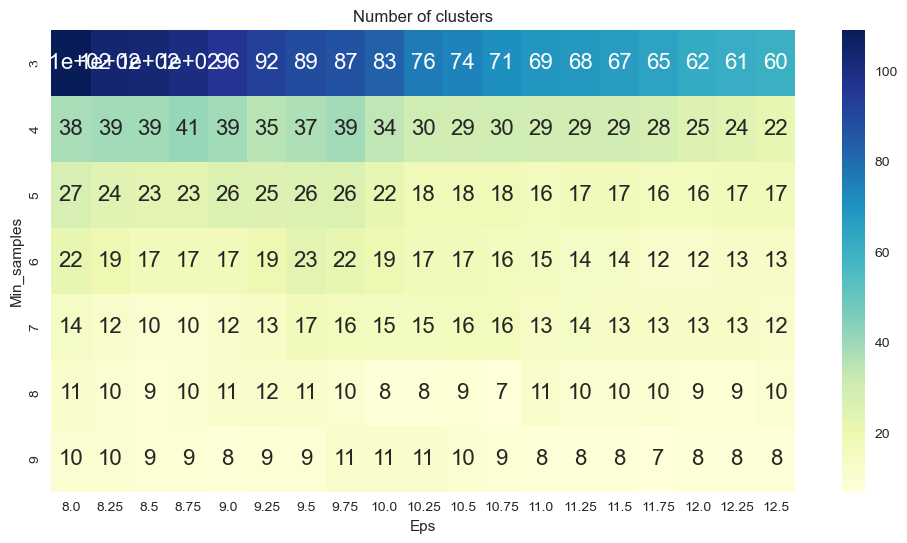

In [41]:
pivot_1 = pd.pivot_table(tmp, values='num_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

Важной особенностью DBSCAN является возможность маркировки выбросов.

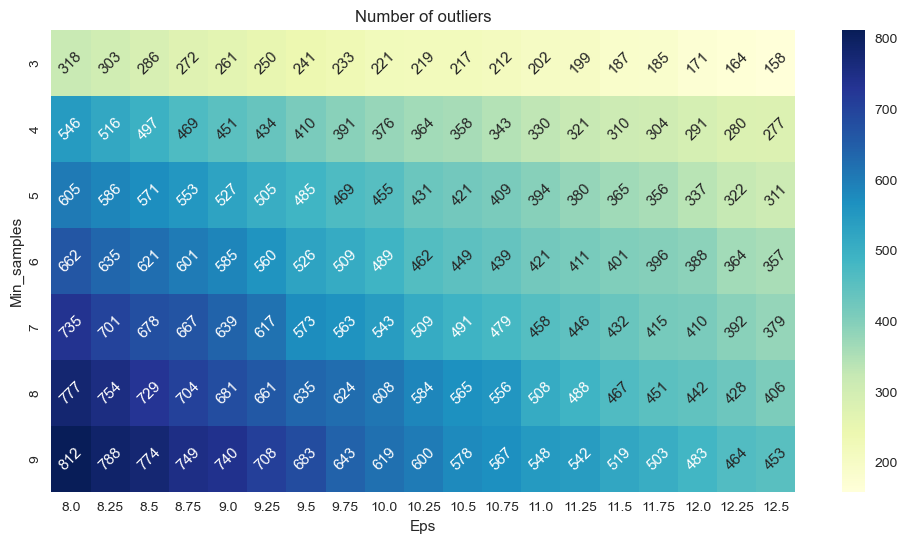

In [43]:
pivot_2 = pd.pivot_table(tmp, values='num_outliers', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_2, annot=True, annot_kws={"size": 11, 'rotation': 45}, cmap="YlGnBu", ax=ax, fmt='.3g')
ax.set_title('Number of outliers')
plt.show()

Оценим качество кластеризации по параметру silhouette score

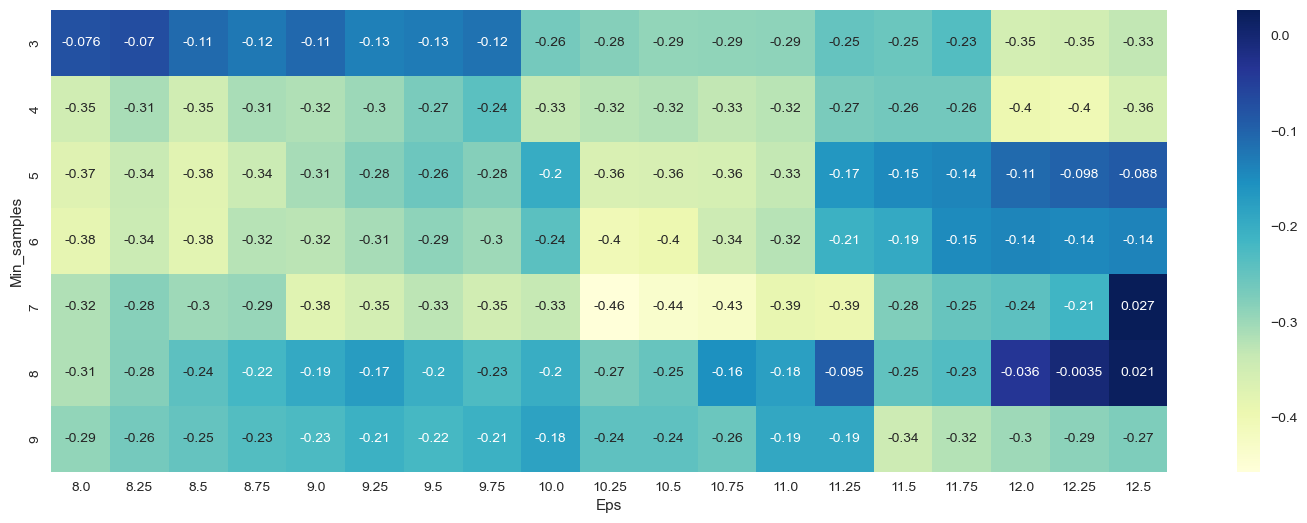

In [45]:
pivot_3 = pd.pivot_table(tmp, values='sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_3, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Максимум в 0.027 достигается при eps = 12.5 и min_samples = 7

In [47]:
eps, min_samples = DBSCAN_params[np.argmax(sil_score)]
print(f"min_samples: {min_samples}, eps: {eps}")

min_samples: 7, eps: 12.5


сохраним метки кластеров в датасет

In [49]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X3)

df['cluster_dbscan'] = dbscan.labels_

df.groupby('cluster_dbscan').size()

cluster_dbscan
-1     379
 0     502
 1      21
 2     128
 3       7
 4       9
 5      19
 6       4
 7      13
 8      12
 9      10
 10      8
 11     12
dtype: int64

In [50]:
plot_3d('cluster_dbscan')

### Выводы по DBSCAN

- Не получилось корректное разделение на кластеры

## HDBSCAN

HDBSCAN является эволицией DBSCAN, для него не нужно подбирать параметр eps

как было сказано в лекции, можно задать min_cluster_size = min_samples и выбирать только 1 параметр (min_samples)

In [54]:
num_clusters = []
num_outliers = []
sil_score = []
# диапазон для поска min_samples/min_cluster_size
params = list(range(3, 10))

for n in params:
    hdbscan = HDBSCAN(min_cluster_size=n, min_samples=n)
    hdbscan.fit(X3)
    num_clusters.append(len(np.unique(hdbscan.labels_[model.labels_>=0])))
    num_outliers.append((hdbscan.labels_==-1).astype(int).sum())
    sil_score.append(silhouette_score(X3, hdbscan.labels_))
    

Посмотрим на количество кластеров и количество выбросов

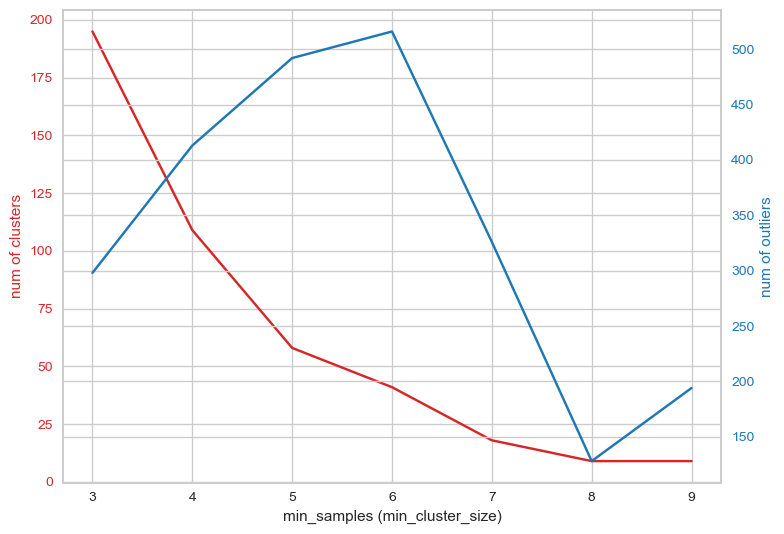

In [56]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('min_samples (min_cluster_size)')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(params, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num of outliers', color=color)  # we already handled the x-label with ax1
ax2.plot(params, num_outliers, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Посмотрим на полученные значения silhouette score

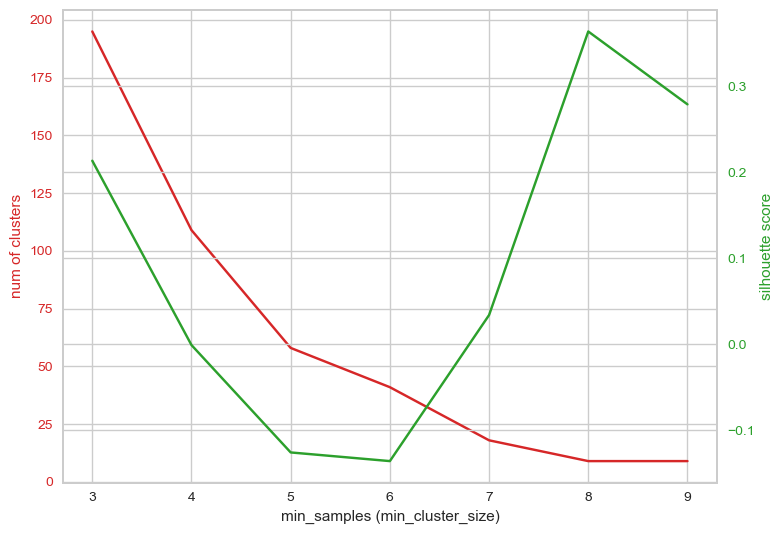

In [58]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('min_samples (min_cluster_size)')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(params, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax2.plot(params, sil_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

С точки зрения silhouette score оптимальное значение 8

In [60]:
min_samples = params[np.argmax(sil_score)]
print(f"min_samples (min_cluster_size): {min_samples}")

min_samples (min_cluster_size): 8


In [61]:
hdbscan = HDBSCAN(min_cluster_size=min_samples, min_samples=min_samples).fit(X3)

df['cluster_hdbscan'] = hdbscan.labels_

df.groupby('cluster_hdbscan').size()

cluster_hdbscan
-1    128
 0     12
 1      9
 2     14
 3     16
 4     22
 5    883
 6     22
 7     18
dtype: int64

In [62]:
plot_3d('cluster_hdbscan')

### Выводы по HDBSCAN

- Результаты значительно лучше, чем у обычного DBSCAN
- Все же не совсем получилось корректное разделение на кластеры

## OPTICS
для OPTICS также необходимо задать только один параметр: min_samples

In [65]:
num_clusters = []
num_outliers = []
sil_score = []
# диапазон для поска min_samples/min_cluster_size
params = list(range(3, 10))

for n in params:
    optics = OPTICS(min_samples=n)
    optics.fit(X3)
    num_clusters.append(len(np.unique(optics.labels_[model.labels_>=0])))
    num_outliers.append((optics.labels_==-1).astype(int).sum())
    sil_score.append(silhouette_score(X3, optics.labels_))
    

посмотрим на количество кластеров и количество выбросов

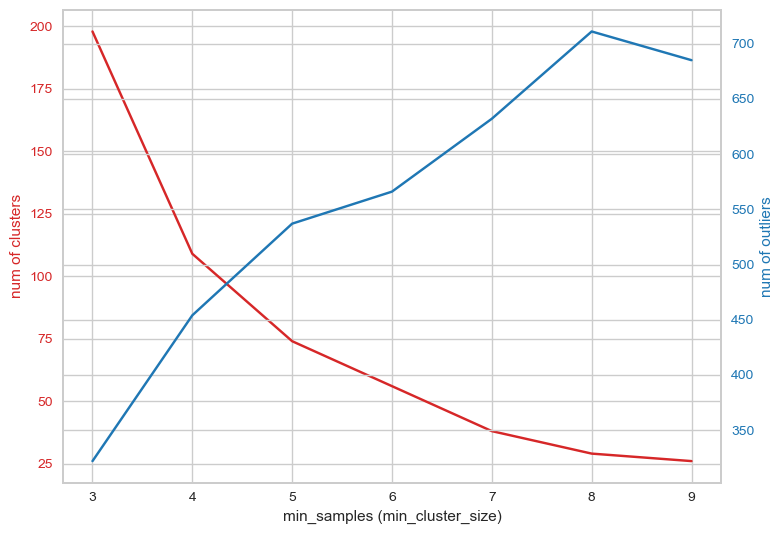

In [67]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('min_samples (min_cluster_size)')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(params, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num of outliers', color=color)  # we already handled the x-label with ax1
ax2.plot(params, num_outliers, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

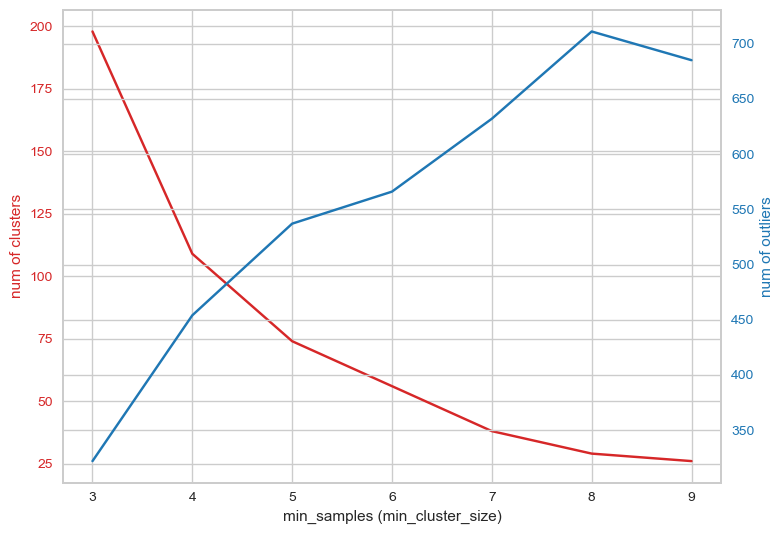

In [68]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('min_samples (min_cluster_size)')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(params, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('num of outliers', color=color)  # we already handled the x-label with ax1
ax2.plot(params, num_outliers, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

посмотрим на полученные значения silhouette score

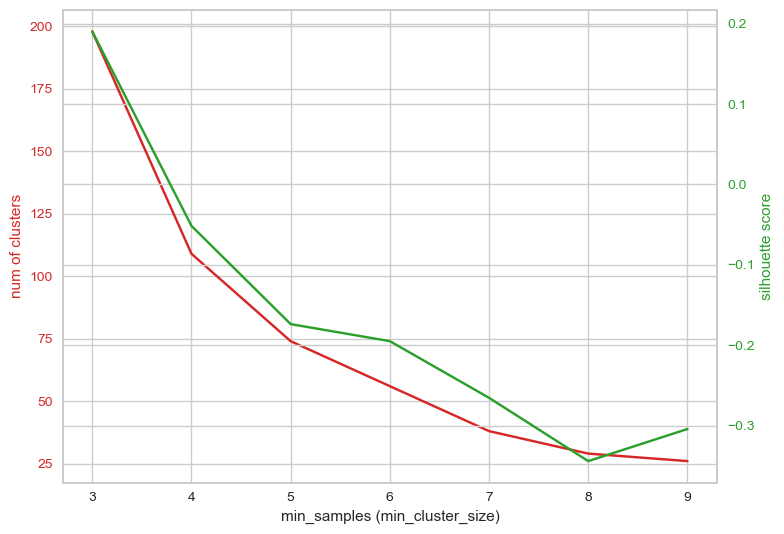

In [70]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('min_samples (min_cluster_size)')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(params, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax2.plot(params, sil_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [71]:
min_samples = params[np.argmax(sil_score)]
print(f"min_samples (min_cluster_size): {min_samples}")

min_samples (min_cluster_size): 3


In [72]:
optics = OPTICS(min_samples=min_samples).fit(X3)

df['cluster_optics'] = optics.labels_

df.groupby('cluster_optics').size()

cluster_optics
-1      322
 0        3
 1        3
 2        6
 3        4
       ... 
 192      5
 193      3
 194      4
 195      4
 196      3
Length: 198, dtype: int64

In [73]:
plot_3d('cluster_optics')

### Выводы по Optics

- Огромное число кластеров, метод совсем не сработал

## Mean Shift

в алгоритме Mean Shift в качестве параметра задается ширина полосы (bandwidth)

в scikit-learn есть отдельная функция для выбора этого параметра (оценивает расстояния от точек до N соседей в KNN, где quantile задает параметр N как долю от всей выборки или батча)

In [76]:
params = np.arange(0.01, 0.21, 0.01)
num_clusters = []
sil_score = []
bandwidths = []

for quantile in params:
    bandwidth = estimate_bandwidth(X3, quantile=quantile)
    mean_shift = MeanShift(bandwidth=bandwidth).fit(X3)
    bandwidths.append(bandwidth)
    num_clusters.append(len(np.unique(mean_shift.labels_)))
    if len(np.unique(mean_shift.labels_)) == 1:
        sil_score.append(0.0)
    else:
        sil_score.append(silhouette_score(X3, mean_shift.labels_))

Посмотрим на график silhouette score

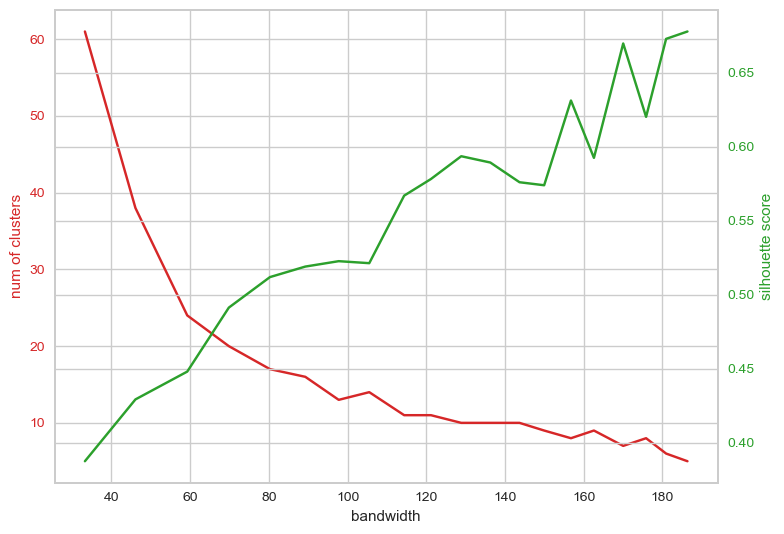

In [78]:
fig, ax1 = plt.subplots()

color='tab:red'
ax1.set_xlabel('bandwidth')
ax1.set_ylabel('num of clusters', color='tab:red')
ax1.plot(bandwidths, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax2.plot(bandwidths, sil_score, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [79]:
quantile = params[np.argmax(sil_score)]
bandwidth = bandwidths[np.argmax(sil_score)]
print('quantile: {:.2f}, bandwidth: {:.2f}'.format(quantile, bandwidth))

quantile: 0.20, bandwidth: 186.37


In [80]:
bandwidth = estimate_bandwidth(X3, quantile=quantile)
mean_shift = MeanShift(bandwidth=bandwidth).fit(X3)

df['cluster_meanshift'] = mean_shift.labels_

df.groupby('cluster_meanshift').size()

cluster_meanshift
0    996
1     19
2    102
3      4
4      3
dtype: int64

In [81]:
plot_3d('cluster_meanshift')

### Выводы по MeanShift

- Отработал неплохо, кластера действительно более-менее отделяемы
- Выбросы отнесены в отдельный кластер, не совсем есть хорошо (тем не менее, тут смотря как ставить исходную задачу).

## Agglomerative Hierarchial Clustering
В аглометративной кластеризации мы стоим дендрограмму - упорядоченные разбиения всей выборки от $1$ кластера, содержащего все точки, до $N$ кластеров по $1$ точке в каждом.

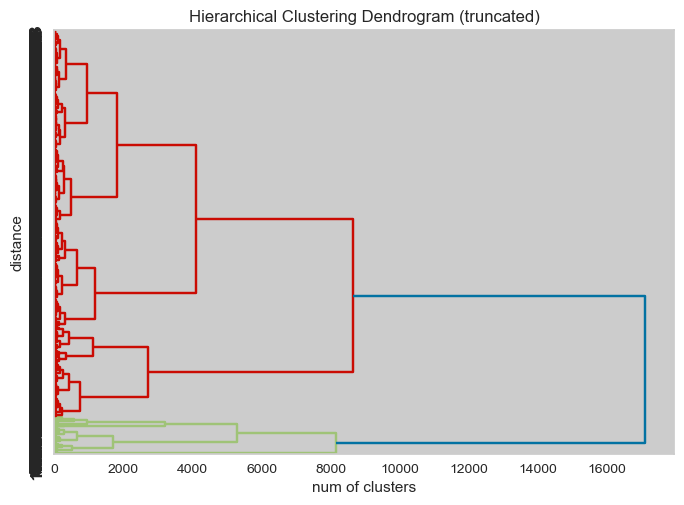

In [84]:
# используем метод Ward, который объединяет по критерию минимальной суммы квадратов расстояний между парами точек двух кластеров
H_cluster = linkage(X3,'ward')

# построим график
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('num of clusters')
plt.ylabel('distance')

dendrogram(
    H_cluster,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
    orientation='right'
)
plt.show()

Какой уровень разбиения выбрать?

Попробуем обратиться к silhouette score

In [86]:
# переберем значение количества кластеров от 2 до 50
params = list(range(2, 51))
num_clusters = []
sil_score = []

for n_clusters in params:
    aglom_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X3)
    num_clusters.append(len(np.unique(aglom_clust.labels_)))
    sil_score.append(silhouette_score(X3, aglom_clust.labels_))
    

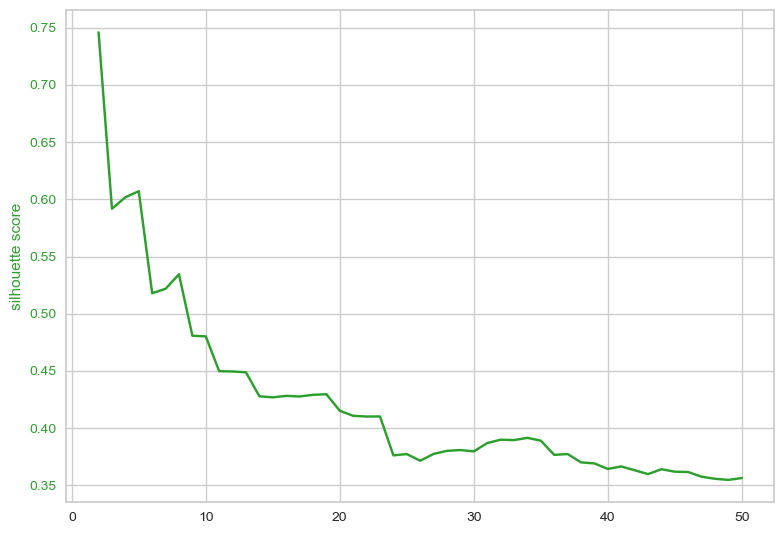

In [87]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax1.plot(params, sil_score, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [88]:
n_clusters = params[np.argmax(sil_score)]
print(f"n_clusters: {n_clusters}")

n_clusters: 2


In [89]:
aglom_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(X3)

df['cluster_agglomerative'] = aglom_clust.labels_

df.groupby('cluster_agglomerative').size()

cluster_agglomerative
0    1024
1     100
dtype: int64

In [90]:
plot_3d('cluster_agglomerative')

### Выводы по Hierarchial Clustering

- Кажется, получилось (снова же, смотря как ставить исходную задачу);
- Четкое разделение на 2 кластера!

## Итоги

Посмотрим на сводную статистику

In [93]:
algorithms = [
    'cluster_kmeans',
    'cluster_dbscan',
    'cluster_hdbscan',
    'cluster_optics',
    'cluster_meanshift',
    'cluster_agglomerative'
]


In [94]:
overview = []
for algo in algorithms:
    n_clusters = df[df[algo]>=0][algo].drop_duplicates().shape[0]
    n_outliers = df[df[algo]==-1].shape[0]
    sil_score = silhouette_score(df[['age', 'income', 'debt']], df[algo])
    sizes = df[df[algo]>=-1].groupby(algo).size().to_frame('size').reset_index()
    min_size = sizes['size'].min()
    max_size = sizes['size'].max()
    avg_size = round(sizes['size'].mean())
    overview.append((algo[8:], n_clusters, n_outliers, sil_score, min_size, max_size, avg_size))
overview = pd.DataFrame(overview, columns=[
    'алгоритм', 'количество кластеров', 'количество выбросов', 'silhouette score',
    'минимальный размер кластера', 'максимальный размер кластера', 'средний размер кластера'
])
overview.head(len(algorithms))

алгоритм  количество кластеров  количество выбросов  silhouette score  \
0         kmeans                     4                    0          0.609303   
1         dbscan                    12                  379          0.027194   
2        hdbscan                     8                  128          0.363458   
3         optics                   197                  322          0.190270   
4      meanshift                     5                    0          0.677805   
5  agglomerative                     2                    0          0.745890   

   минимальный размер кластера  максимальный размер кластера  \
0                            7                           733   
1                            4                           502   
2                            9                           883   
3                            3                           322   
4                            3                           996   
5                          100                          1024   

   средний размер кластера  
0                      281  
1                       86  
2                      125  
3                        6  
4                      225  
5                      562

Посчитаем количество несовпадающих пар следующим образом:

* Для алгоритма А пробегаемся для каждого кластера по каждой паре точек;

* Проверяем совпадают ли для этой пары метки кластеров, полученных в алгоритме B;

* Считаем количество несовпавших пар и делим на общее количество пар;

Это несимметричная мера!

In [96]:
mismatches = []

for col_1 in algorithms:
    for col_2 in algorithms:
        mismatch = 0
        all_pairs = 0
        if col_1 == col_2:
            pass
        else:
            clusters = df[col_1].drop_duplicates().tolist()
            for cluster in clusters:
                if cluster >= 0:
                    values = df[df[col_1]==cluster][col_2].tolist()
                    mismatch += sum(int(v1!=v2) for v1 in values for v2 in values)
                    all_pairs += len(values)**2
        mismatches.append((col_1[8:], col_2[8:], mismatch/max(all_pairs-df.shape[0], 1), mismatch, all_pairs))

In [97]:
overall_pivot = \
pd.DataFrame(mismatches, columns=['base', 'check', 'mismatch', 'a', 'b']).\
pivot(values='mismatch', index='base', columns='check')

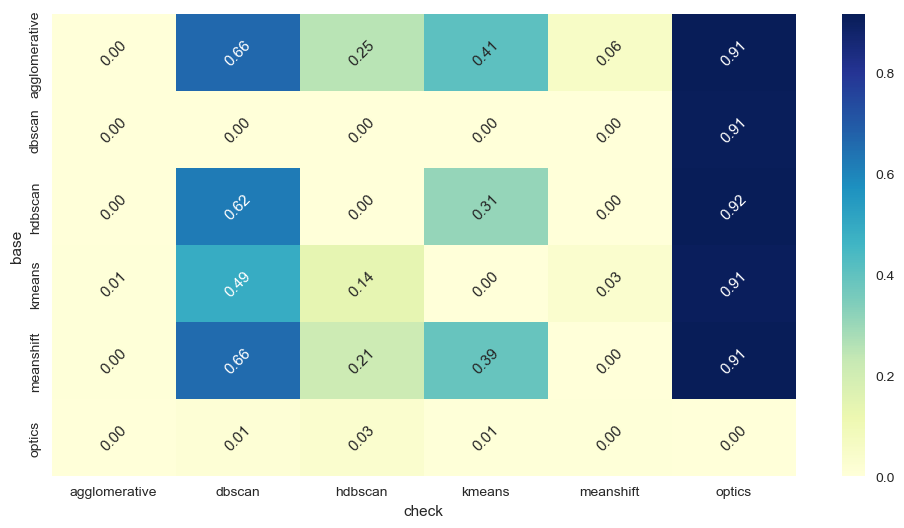

In [98]:
fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(overall_pivot, annot=True, annot_kws={"size": 11, 'rotation': 45}, cmap="YlGnBu", ax=ax, fmt='.2f')
plt.show()

### Дописать

В основном отличия есть между OPTICS и другими алгоритмами.

Это связано с тем, что OPTICS разбил на 197 кластеров (у других алгоритмов кластеры более крупные).

# Выводы:

По результатам проделанной работы, можно подсветить следующие аспекты:

- Плотностные методы из одного семесства (DBSCAN, HDBSCAN, Optics) показали себя достаточно плохо - по метрике silhouette score они заметно хуже других алгоритмов;
- K-Means++, MeanShift, Agglomerative Hierarchial Clustering показали более-менее схожие в контексте данной метрики показатели;
- Agglomerative Hierarchial Clustering показал наилучший результат по метрике;
- В целом, количество кластеров, которое нам необходимо, зависит от поставленной нами задачи, но, лично мне больше всего нравится работа Agglomerative Hierarchial Clustering - четко выделенные два кластера, скорее всего, как раз и соответствующие выходу / не выходу клиента в дефолт;
- Тем не менее, K-Means++ и MeanShift вполне имеют место быть, - визуально кластера тоже относительно неплохо отделены; в целом, необязательно строить стратегию по работе именно с группами выйдет / не выйдет в дефолт, можно вполне использовать более сегментированные кластера, и работать с клиентами уже на уровне некоторых более гранулярных групп;
- Подытоживая, мне нравится работа Agglomerative Hierarchial Clustering, но для итоговой модели я бы попробовал более глубокого поработать с топ-3 алгоритмами и выбирать конкретный из них уже из хотя из четко поставленной бизнес-задачи, цели.